In [236]:
import os
import re
import pymongo
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# !pip install nltk
import nltk
# nltk.download()
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
if not os.path.exists('entries.csv'):
    uri = "mongodb+srv://" + urllib.parse.quote("user") + ":" + urllib.parse.quote("Pizza.network1") + "@dentries-nsb6p.mongodb.net/test?retryWrites=true&w=majority"
    client = pymongo.MongoClient(uri)
    db = client.diary_entries_db
    db.list_collection_names()
    collection = db['diary_entries']
    df = pd.DataFrame(list(collection.find()))
    df.to_csv('entries.csv')
else:
    df = pd.read_csv('entries.csv')

# Clean Data

In [4]:
df = df.drop(columns=['_id', 'date', 'startTime', 'endTime'])

In [5]:
df['content'] = df['content'].str.lower().str.replace(r'[.?,!]', '')

In [8]:
df['goodMood'] = df['goodMood'].replace({True: 1, False: 0})

In [9]:
df.head()

,title,content,goodMood
0,11-9-2017,hello how should i start umm well i am making ...,1
1,11-11-2017,ok so new plan i just sleep after i take my sh...,1
2,11-13-2017,well a lot has happened okay sorry for not wri...,0
3,11-14-2017,damn it i overslept again i hate myself right ...,0
4,11-15-2017,so i went on a run today yodai was there too t...,1


# EDA

In [17]:
df.loc[df['goodMood'] == 0].shape[0], df.loc[df['goodMood'] == 1].shape[0]

(100, 77)

In [51]:
def flatten(ll):
    s = []
    for l in ll:
        s.extend(l)
    return s
    
unique_words = pd.DataFrame(pd.Series(flatten(df['content'].str.split(' '))).value_counts(), columns=['count'])
unique_words['length'] = unique_words.index.str.len()
number_of_words = np.sum(unique_words['count'])
unique_words.head()

,count,length
i,3514,1
to,1674,2
the,1183,3
a,888,1
is,850,2


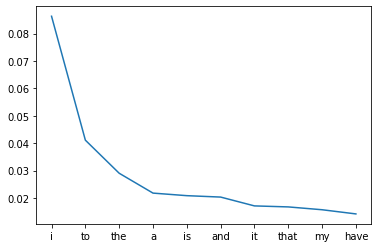

In [12]:
plt.plot(unique_words['count'][:10] / number_of_words);

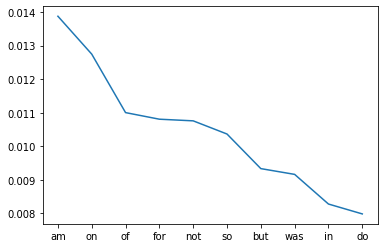

In [13]:
plt.plot(unique_words['count'][10:20] / number_of_words);

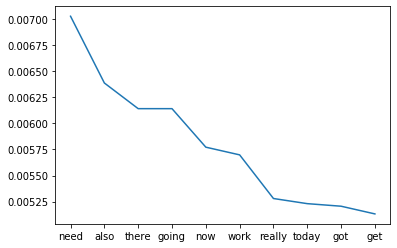

In [14]:
plt.plot(unique_words['count'][20:30] / number_of_words);

## Helper Functions

In [34]:
def acc_pre_rec(y, y_hat):
    tp = np.sum((y == y_hat) & (y == 1))
    tn = np.sum((y == y_hat) & (y == 0))
    fp = np.sum((y != y_hat) & (y == 0))
    fn = np.sum((y != y_hat) & (y == 1))
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return accuracy, precision, recall

In [61]:
def tf(term, corpus):
    counts = corpus.str.count(re.escape(term))
    return counts / corpus.shape[0]

In [57]:
def idf(term, corpus):
    return np.log(corpus.shape[0]) / np.sum(corpus.str.contains(term, regex=False))

In [46]:
def tfidf(term, corpus):
    return tf(term, corpus) * idf(term, corpus)

# VADER

In [18]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

vader_df = df.copy()

In [26]:
vader_analyzer = SentimentIntensityAnalyzer()
for i in range(vader_df.shape[0]):
    result = vader_analyzer.polarity_scores(vader_df.loc[i, 'content'])
    vader_df.loc[i, 'neg'] = result['neg']
    vader_df.loc[i, 'neu'] = result['neu']
    vader_df.loc[i, 'pos'] = result['pos']
    vader_df.loc[i, 'compound'] = result['compound']

vader_df.head()

,title,content,goodMood,neg,neu,pos,compound
0,11-9-2017,hello how should i start umm well i am making ...,1,0.050,0.872,0.078,0.7269
1,11-11-2017,ok so new plan i just sleep after i take my sh...,1,0.069,0.787,0.144,0.9230
2,11-13-2017,well a lot has happened okay sorry for not wri...,0,0.140,0.758,0.102,-0.9386
3,11-14-2017,damn it i overslept again i hate myself right ...,0,0.095,0.807,0.099,0.4218
4,11-15-2017,so i went on a run today yodai was there too t...,1,0.107,0.835,0.058,-0.7692


In [35]:
y = vader_df['goodMood']
y_hat = (vader_df['pos'] > vader_df['neg']).astype(int)
acc_pre_rec(y, y_hat)

(0.576271186440678, 0.5081967213114754, 0.8051948051948052)

# TFIDF

In [333]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_df = df.copy()

In [62]:
tfidf_data = {word: tfidf(word, tfidf_df['content']) for word in unique_words.index}

In [64]:
tfidf_data_df = pd.DataFrame(tfidf_data)

In [65]:
tfidf_data_df.head()

,i,to,the,a,is,and,it,that,my,have,...,dizzy,tabs,supports,80%,coke,haas,demo,eecs126,colors,careful
0,0.011731,0.001652,0.001521,0.014374,0.001345,0.001057,0.001014,0.000183,0.000705,0.000187,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.009913,0.001487,0.000845,0.011565,0.001008,0.000705,0.001014,0.000731,0.000705,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.018670,0.003304,0.002028,0.019496,0.002521,0.001233,0.000845,0.001462,0.000352,0.000562,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.012061,0.001652,0.001859,0.011731,0.001513,0.000705,0.001183,0.000914,0.000529,0.000375,...,0.0,0.029244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.007435,0.000991,0.001183,0.006774,0.001008,0.000000,0.000507,0.000548,0.000529,0.000187,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
np.mean(tfidf_data_df, axis=0).nlargest(10)

      0.182396
a     0.012086
i     0.011910
s     0.008243
h     0.007296
r     0.006935
m     0.004691
g     0.003711
th    0.003571
c     0.003153
dtype: float64

In [102]:
data_train, data_test, y_train, y_test = train_test_split(tfidf_df['content'], tfidf_df['goodMood'], 
                                                    test_size=0.2, random_state = 42)

In [104]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(data_train)

X_test = vectorizer.transform(data_test)

feature_names = vectorizer.get_feature_names()
feature_names[:5]

['00', '000webhost', '04', '10', '100']

### Logistic Regression

In [111]:
tfidf_logistic_model = LogisticRegression(solver='lbfgs')
tfidf_logistic_model.fit(X_train, y_train)

y_hat = tfidf_logistic_model.predict(X_test)
acc_pre_rec(y_test, y_hat)

(0.5833333333333334, 1.0, 0.11764705882352941)

### Random Forests

In [115]:
tfidf_rfc_model = RandomForestClassifier()
tfidf_rfc_model.fit(X_train, y_train)

y_hat = tfidf_rfc_model.predict(X_test)
acc_pre_rec(y_test, y_hat)

/home/shershah/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(0.5555555555555556, 0.5555555555555556, 0.29411764705882354)

# Bag of Words

In [127]:
from nltk.corpus import stopwords
stopwords = list(stopwords.words('english'))

bow_df = df.copy()

In [129]:
bow_unique_words = unique_words.loc[~unique_words.index.isin(stopwords)]

In [124]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [135]:
bow_unique_words.head()

,count,length
need,286,4
also,260,4
going,250,5
work,232,4
really,215,6


In [140]:
data_train, data_test, y_train, y_test = train_test_split(bow_df['content'], bow_df['goodMood'], 
                                                    test_size=0.2, random_state = 42)

In [143]:
X_train = pd.DataFrame({word: data_train.str.count(re.escape(word)) for word in bow_unique_words.index})
X_test = pd.DataFrame({word: data_test.str.count(re.escape(word)) for word in bow_unique_words.index})

In [146]:
bow_logistic_model = LogisticRegression(solver='lbfgs')
bow_logistic_model.fit(X_train, y_train)

y_hat = bow_logistic_model.predict(X_test)
acc_pre_rec(y_test, y_hat)

/home/shershah/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


(0.6111111111111112, 0.6153846153846154, 0.47058823529411764)

In [340]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])
text_clf = text_clf.fit(data_train, y_train)

In [342]:
acc_pre_rec(y_test, text_clf.predict(data_test))

(0.5555555555555556, 1.0, 0.058823529411764705)

In [346]:
from sklearn.linear_model import SGDClassifier

text_clf_svm = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                          alpha=1e-3, random_state=42)),
])

text_clf_svm.fit(data_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf-svm',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                  

In [347]:
acc_pre_rec(y_test, text_clf_svm.predict(data_test))

(0.6388888888888888, 0.6111111111111112, 0.6470588235294118)

In [352]:
data_test

19     hey so now i am adding titles to my diary entr...
45     so i am currently working on data science stuf...
139    i am back home i have lot to do finals were br...
30     so i went to virginia the plane ride was long ...
67     i am realy sleepy right now i don't know why i...
16     sorry for not writing soon i have been busy an...
119    well it is now official spring break i finishe...
173    i got paid finally sure it is only a fraction ...
109    my family execpt sama went off to pakistan yes...
140    so i had my phone interview today with northru...
24     it has been a while hasn't it i feel so tired ...
161    classes start tomorrow i am not ready nor do i...
41     so i am making chili i bought all the ingredie...
118    sorry i have not written in a while i have not...
15     sorry for not writing in a while i just got re...
111    i am writting this from my bed the day was lon...
113    so today was sarah's birthday she got a cake a...
82     hey i really need to get

# N-Gram

### Bigram

In [185]:
bigram_df = df.copy()

In [186]:
bigrams_train = [list(nltk.bigrams(nltk.word_tokenize(s))) for s in bigram_df['content']]
bigrams_train = [[a + ' ' + b for a, b in l] for l in bigrams_train]
_bigrams_train = np.unique(np.array(bigrams_train))
bigrams_train = []
for bigrams in _bigrams_train:
            bigrams_train.extend(bigrams)

[('so', 'the'),
 ('the', 'backend'),
 ('backend', 'is'),
 ('is', 'now'),
 ('now', 'connected'),
 ('connected', 'to'),
 ('to', 'mongodb'),
 ('mongodb', 'this'),
 ('this', 'means'),
 ('means', 'that'),
 ('that', 'there'),
 ('there', 'are'),
 ('are', 'no'),
 ('no', 'more'),
 ('more', 'files'),
 ('files', 'to'),
 ('to', 'worry'),
 ('worry', 'about'),
 ('about', 'everything'),
 ('everything', 'is'),
 ('is', 'stored'),
 ('stored', 'in'),
 ('in', 'the'),
 ('the', 'cloud'),
 ('cloud', 'it'),
 ('it', 'is'),
 ('is', 'also'),
 ('also', 'awesome'),
 ('awesome', 'because'),
 ('because', 'i'),
 ('i', 'now'),
 ('now', 'know'),
 ('know', 'the'),
 ('the', 'mean'),
 ('mean', 'stack'),
 ('stack', 'which'),
 ('which', 'is'),
 ('is', 'mongodb'),
 ('mongodb', 'expressjs'),
 ('expressjs', 'angularjs'),
 ('angularjs', 'and'),
 ('and', 'nodejs'),
 ('nodejs', 'i'),
 ('i', 'am'),
 ('am', 'going'),
 ('going', 'to'),
 ('to', 'put'),
 ('put', 'that'),
 ('that', 'on'),
 ('on', 'my'),
 ('my', 'resume'),
 ('resume', '

In [187]:
data_train, data_test, y_train, y_test = train_test_split(bigram_df['content'], bigram_df['goodMood'], 
                                                    test_size=0.2, random_state = 42)

In [188]:
X_train = pd.DataFrame({word: data_train.str.count(re.escape(word)) for word in bigrams_train})
X_test = pd.DataFrame({word: data_test.str.count(re.escape(word)) for word in bigrams_train})

In [189]:
bigram_logistic_model = LogisticRegression(solver='lbfgs')
bigram_logistic_model.fit(X_train, y_train)

y_hat = bigram_logistic_model.predict(X_test)
acc_pre_rec(y_test, y_hat)

(0.6111111111111112, 0.6153846153846154, 0.47058823529411764)

### Trigram

In [195]:
trigram_df = df.copy()

In [196]:
trigrams_train = [list(nltk.trigrams(nltk.word_tokenize(s))) for s in trigram_df['content']]
trigrams_train = [[a + ' ' + b + 'c' for a, b, c in l] for l in trigrams_train]
_trigrams_train = np.unique(np.array(trigrams_train))
trigrams_train = []
for trigrams in _trigrams_train:
            trigrams_train.extend(trigrams)

In [197]:
data_train, data_test, y_train, y_test = train_test_split(bigram_df['content'], bigram_df['goodMood'], 
                                                    test_size=0.2, random_state = 42)

In [198]:
X_train = pd.DataFrame({word: data_train.str.count(re.escape(word)) for word in trigrams_train})
X_test = pd.DataFrame({word: data_test.str.count(re.escape(word)) for word in trigrams_train})

In [200]:
trigram_logistic_model = LogisticRegression(solver='lbfgs')
trigram_logistic_model.fit(X_train, y_train)

y_hat = trigram_logistic_model.predict(X_test)
acc_pre_rec(y_test, y_hat)

(0.5555555555555556, 1.0, 0.058823529411764705)

# Word2Vec

In [239]:
import keras as K
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

w2v_df = df.copy()

Using TensorFlow backend.


In [243]:
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(w2v_df['content'])

max_length = max([len(s.split()) for s in w2v_df['content']])
vocab_size = len(tokenizer_obj.word_index) + 1

In [245]:
data_train, data_test, y_train, y_test = train_test_split(w2v_df['content'], w2v_df['goodMood'], 
                                                    test_size=0.2, random_state = 42)

X_train_tokens = tokenizer_obj.texts_to_sequences(data_train)
X_test_tokens = tokenizer_obj.texts_to_sequences(data_test)

X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

In [246]:
EMBEDDING_DIM = 100

In [260]:
w2v_model = K.models.Sequential()
w2v_model.add(K.layers.embeddings.Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
w2v_model.add(K.layers.GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
w2v_model.add(K.layers.Dense(1, activation='sigmoid'))

w2v_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
w2v_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 675, 100)          340200    
_________________________________________________________________
gru_6 (GRU)                  (None, 32)                12768     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 353,001
Trainable params: 353,001
Non-trainable params: 0
_________________________________________________________________


In [265]:
w2v_model.fit(X_train_pad, y_train, batch_size=32, epochs=10, validation_data=(X_test_pad, y_test), verbose=2)

Train on 141 samples, validate on 36 samples
Epoch 1/10
 - 1s - loss: 0.6855 - accuracy: 0.5745 - val_loss: 0.6982 - val_accuracy: 0.5278
Epoch 2/10
 - 1s - loss: 0.6836 - accuracy: 0.5745 - val_loss: 0.6962 - val_accuracy: 0.5278
Epoch 3/10
 - 1s - loss: 0.6826 - accuracy: 0.5745 - val_loss: 0.6951 - val_accuracy: 0.5278
Epoch 4/10
 - 1s - loss: 0.6810 - accuracy: 0.5745 - val_loss: 0.6948 - val_accuracy: 0.5278
Epoch 5/10
 - 1s - loss: 0.6840 - accuracy: 0.5745 - val_loss: 0.6946 - val_accuracy: 0.5278
Epoch 6/10
 - 1s - loss: 0.6792 - accuracy: 0.5745 - val_loss: 0.6945 - val_accuracy: 0.5278
Epoch 7/10
 - 1s - loss: 0.6826 - accuracy: 0.5745 - val_loss: 0.6949 - val_accuracy: 0.5278
Epoch 8/10
 - 1s - loss: 0.6831 - accuracy: 0.5745 - val_loss: 0.6950 - val_accuracy: 0.5278
Epoch 9/10
 - 1s - loss: 0.6794 - accuracy: 0.5745 - val_loss: 0.6951 - val_accuracy: 0.5278
Epoch 10/10
 - 1s - loss: 0.6866 - accuracy: 0.5745 - val_loss: 0.6943 - val_accuracy: 0.5278


In [310]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

AttributeError: ("module 'bert' has no attribute 'run_classifier'", 'occurred at index 0')

In [311]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    with tf.Graph().as_default():
        bert_module = hub.Module(BERT_MODEL_HUB)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        with tf.Session() as sess:
            vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
    return bert.tokenization.FullTokenizer(
        vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


AttributeError: module 'tensorflow' has no attribute 'Session'

In [312]:
tokenizer.tokenize(train['sentence'][0])

NameError: name 'tokenizer' is not defined

In [313]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

AttributeError: module 'bert' has no attribute 'run_classifier'

In [314]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
    """Creates a classification model."""

    bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
    bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
    bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
    output_layer = bert_outputs["pooled_output"]

    hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
    output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
        output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
        one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

        predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
        # If we're predicting, we want predicted labels and the probabiltiies.
        if is_predicting:
            return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
        per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        return (loss, predicted_labels, log_probs)


In [315]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
    """Returns `model_fn` closure for TPUEstimator."""
    def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
        """The `model_fn` for TPUEstimator."""

        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]

        is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
        if not is_predicting:

            (loss, predicted_labels, log_probs) = create_model(
                is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            train_op = bert.optimization.create_optimizer(
                loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

          # Calculate evaluation metrics. 
            def metric_fn(label_ids, predicted_labels):
                accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
                f1_score = tf.contrib.metrics.f1_score(
                    label_ids,
                    predicted_labels)
                auc = tf.metrics.auc(
                    label_ids,
                    predicted_labels)
                recall = tf.metrics.recall(
                    label_ids,
                    predicted_labels)
                precision = tf.metrics.precision(
                    label_ids,
                    predicted_labels) 
                true_pos = tf.metrics.true_positives(
                    label_ids,
                    predicted_labels)
                true_neg = tf.metrics.true_negatives(
                    label_ids,
                    predicted_labels)   
                false_pos = tf.metrics.false_positives(
                    label_ids,
                    predicted_labels)  
                false_neg = tf.metrics.false_negatives(
                    label_ids,
                    predicted_labels)
                return {
                    "eval_accuracy": accuracy,
                    "f1_score": f1_score,
                    "auc": auc,
                    "precision": precision,
                    "recall": recall,
                    "true_positives": true_pos,
                    "true_negatives": true_neg,
                    "false_positives": false_pos,
                    "false_negatives": false_neg
                }

            eval_metrics = metric_fn(label_ids, predicted_labels)

            if mode == tf.estimator.ModeKeys.TRAIN:
                return tf.estimator.EstimatorSpec(mode=mode,
                    loss=loss,
                    train_op=train_op)
            else:
                return tf.estimator.EstimatorSpec(mode=mode,
                    loss=loss,
                    eval_metric_ops=eval_metrics)
        else:
            (predicted_labels, log_probs) = create_model(
                is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            predictions = {
              'probabilities': log_probs,
              'labels': predicted_labels
              }
            return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
    return model_fn

In [316]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [317]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

NameError: name 'train_features' is not defined

In [318]:
# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [319]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


NameError: name 'num_train_steps' is not defined

In [320]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

AttributeError: module 'bert' has no attribute 'run_classifier'

In [321]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!


NameError: name 'estimator' is not defined

In [322]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

NameError: name 'run_classifier' is not defined

In [323]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

NameError: name 'estimator' is not defined

In [324]:
def getPrediction(in_sentences):
    labels = ["Negative", "Positive"]
    input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] # here, "" is just a dummy label
    input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
    predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
    predictions = estimator.predict(predict_input_fn)
    return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [325]:
pred_sentences = [
  "That movie was absolutely awful",
  "The acting was a bit lacking",
  "The film was creative and surprising",
  "Absolutely fantastic!"
]

In [326]:
predictions = getPrediction(test['sentence'])

KeyError: 'sentence'

In [327]:
pol = np.array(test['polarity'])

KeyError: 'polarity'

In [328]:
t = 0
for p, i in zip(predictions, pol):
  if (p[2] == 'Positive' and i == 1) or (p[2] == 'Negative' and i == 0):
    t += 1

1 - (t / len(pol))

NameError: name 'predictions' is not defined